# Convergence study

For a given campaign load models for all available freqs and plot
convergence, duration ...


In [ ]:
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import sys
import time
import os
import pickle
import numpy as np
from model_tools import load_model
# visu
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import scipy.io
import h5py
import simulation_campaigns
import collections
from post_process import compute_errors, plot_campaign, check_time_vectors, plot_errors, plot_y, plot_durations, save_dof, compute_errors_rel
import datetime

## Pick up results file(s)

Campaign parameters are supposed to be saved in a 'pkl' file

Load it and get sets of results (one set = a model run for different values of frequency)

#### List pkl files available:

In [4]:
ls campaign*.pkl

campaign0212.pkl         campaign_new_0612.pkl
campaign_1812.pkl        campaign_short_1312.pkl


#### Load a pkl and print configs and freqs

In [5]:
import pickle
import subprocess
pklfilename = 'campaign_1812.pkl'
figures_path = 'fig_' + os.path.splitext(pklfilename)[0]
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
#pkl_file = open('campaign_new_0612.pkl', 'rb')
pkl_file = open(pklfilename, 'rb')

remote_data = pickle.load(pkl_file)
for name in remote_data:
    print("Campaign name : " + name)
    if name.find('results') < 0:
        print("Available freqs:")
        print(list(remote_data[name].keys()))
        print("\n")


Campaign name : one_contact0.5
Available freqs:
['5000', '10000']


Campaign name : results_paths
Campaign name : one_contact0.0
Available freqs:
['10000', '5000']


Campaign name : one_contact1.0
Available freqs:
['10000', '5000']


Campaign name : bass0.0
Available freqs:
['31360', '1003520', '62720', '250880', '125440', '501760', '15680', '4014080', '2007040', '64225280', '16056320', '32112640', '128450560', '8028160', '256901120']


Campaign name : bass0.9
Available freqs:
['125440', '250880', '31360', '15680', '62720', '8028160', '2007040', '128450560', '16056320', '32112640', '1003520', '4014080', '64225280', '501760', '256901120']


Campaign name : bass1.0
Available freqs:
['125440', '15680', '250880', '31360', '62720', '501760', '4014080', '8028160', '2007040', '1003520', '32112640', '16056320', '128450560', '64225280', '256901120']


Campaign name : fretless0.0
Available freqs:
['62720', '125440', '31360', '15680', '250880', '501760', '1003520', '2007040', '4014080']


Campaig

## Convergence study

In [6]:
matlab_frets = './bass_guitar/pb2'
matlab_fretless = './fretless_bass_guitar/bsf'
matlab_one_contact = './one_contact/pb1'
errors = {}
freqs = {}
ymin = {}
timers = {}
xref = {}

Load model from file ./results_bass_1812/F_256901120_id_3966461/converted_bass_e0.9_862_256901120.h5
Load model from file ./results_bass_1812/F_15680_id_3966447/converted_bass_e0.9_862_15680.h5
push  15680.0 0
Load model from file ./results_bass_1812/F_31360_id_3966448/converted_bass_e0.9_862_31360.h5
push  31360.0 1
Load model from file ./results_bass_1812/F_62720_id_3966449/converted_bass_e0.9_862_62720.h5
push  62720.0 2
Load model from file ./results_bass_1812/F_125440_id_3966450/converted_bass_e0.9_862_125440.h5
push  125440.0 3
Load model from file ./results_bass_1812/F_250880_id_3966451/converted_bass_e0.9_862_250880.h5
push  250880.0 4
Load model from file ./results_bass_1812/F_501760_id_3966452/converted_bass_e0.9_862_501760.h5
push  501760.0 5
Load model from file ./results_bass_1812/F_1003520_id_3966453/converted_bass_e0.9_862_1003520.h5
push  1003520.0 6
Load model from file ./results_bass_1812/F_2007040_id_3966454/converted_bass_e0.9_862_2007040.h5
push  2007040.0 7
Load m

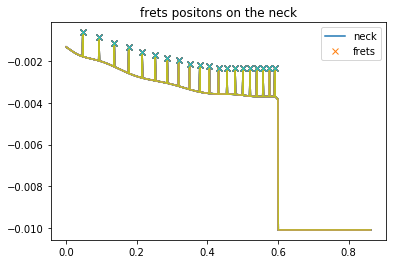

In [13]:
#names = [name for name in remote_data.keys() if name.find('bass') >=0]
dofs = [100, 500, 853]
names=['bass0.9']
#names = [name for name in remote_data.keys() if name.find('fretless') >=0]


for name in names:
    campaign = remote_data[name]
    #if name.find('new') >=0 : 
    #    shift = 2
    #else:
    shift=1
    #if name.find('new2') >=0 : 
    #    shift = 1

#    if name.find('bass') >=0 :
#        matlab_input = matlab_frets
 #   elif name.find('fretless') >= 0:
  #      matlab_input = matlab_fretless
   # elif name.find('one_contact') >=0 :
    #    matlab_input = matlab_one_contact
    fileslist = {}
    results_path = remote_data["results_paths"][1]
    timers[name] = np.zeros((len(campaign), 3))
    j = 0
    for freq in campaign:
        fileslist[np.float(freq)] = os.path.join(results_path, campaign[freq][5])
        timers[name][j, :] = [np.float(freq), np.float(campaign[freq][1]), np.int(campaign[freq][2])]
        j += 1                   
    fileslist = collections.OrderedDict(sorted(fileslist.items()))
    #check_time_vectors(filelist, matlab_frets)
    errors[name], ymin[name], freqs[name], xref[name] = compute_errors(fileslist, dofs=dofs, savedofs=name + '_dofs.mat')

In [ ]:
names = [name for name in remote_data.keys() if name.find('bass') >=0]
dof = 853
for name in names:
    campaign = remote_data[name]
    if name.find('bass') >=0 :
        matlab_input = matlab_frets
    elif name.find('fretless') >= 0:
        matlab_input = matlab_fretless
    fileslist = {}
    results_path = remote_data["results_paths"][1]
    timers[name] = np.zeros((len(campaign), 3))
    j = 0
    for freq in campaign:
        fileslist[np.float(freq)] = os.path.join(results_path, campaign[freq][5])
    fileslist = collections.OrderedDict(sorted(fileslist.items()))
    #print(fileslist)
    #check_time_vectors(filelist, matlab_frets)
    matfile = name + '_dof' + str(dof) + '.mat'
    saved_dof =  save_dof(fileslist, dof, matfile)
    

In [ ]:
import scipy.io as sio
res = sio.loadmat('./bass0.0_dofs.mat')

In [ ]:
res

In [ ]:
fr = res['freqs'][0,:]
dof = res['dof_853']
print(dof.shape)
print(fr.shape)
plt.semilogx(fr, dof[:, 1000], 'o')

### Plot convergence for bass guitar

In [ ]:
figures_path = os.path.join(figures_path, 'fretless')
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
print(figures_path)

In [ ]:
print(errors)
print(figures_path)

In [ ]:
for  name in errors:
    print(name)
    print(len(freqs[name]))
    print(errors[name].shape)

(15, 20)


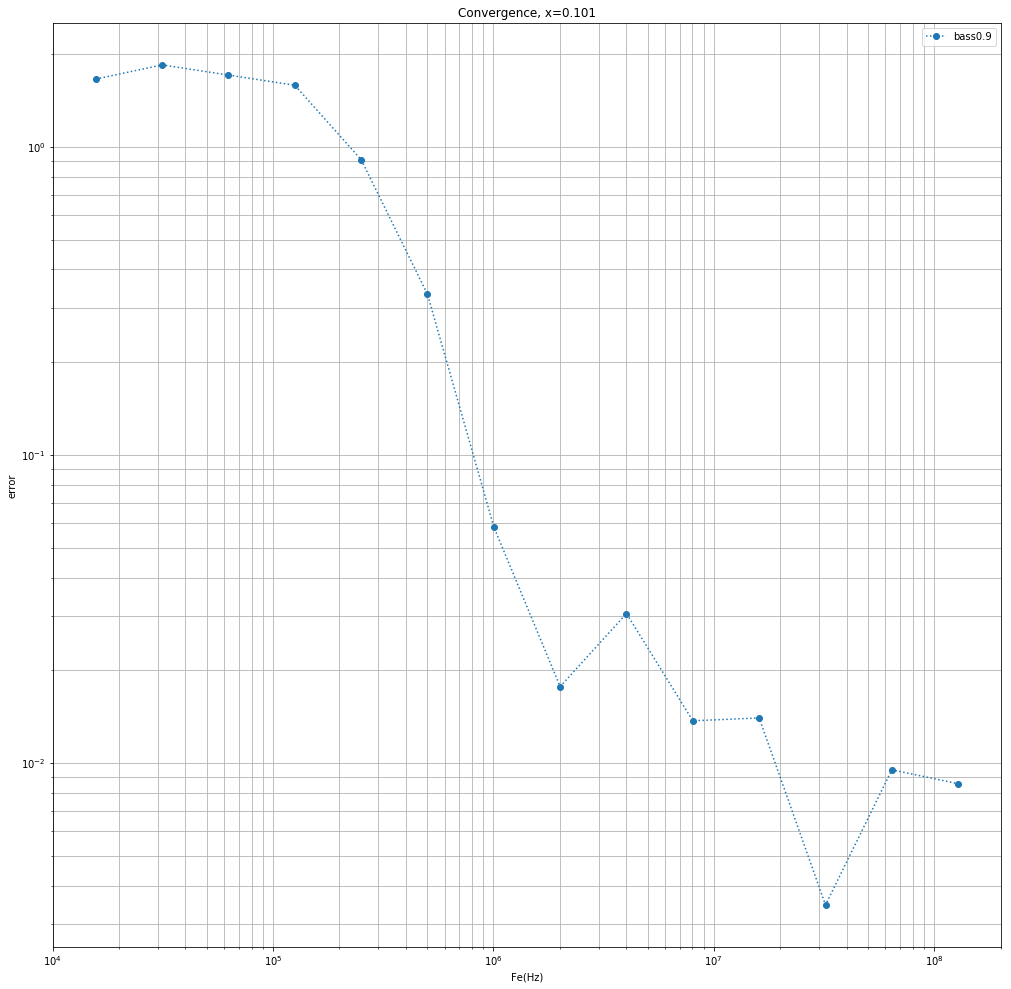

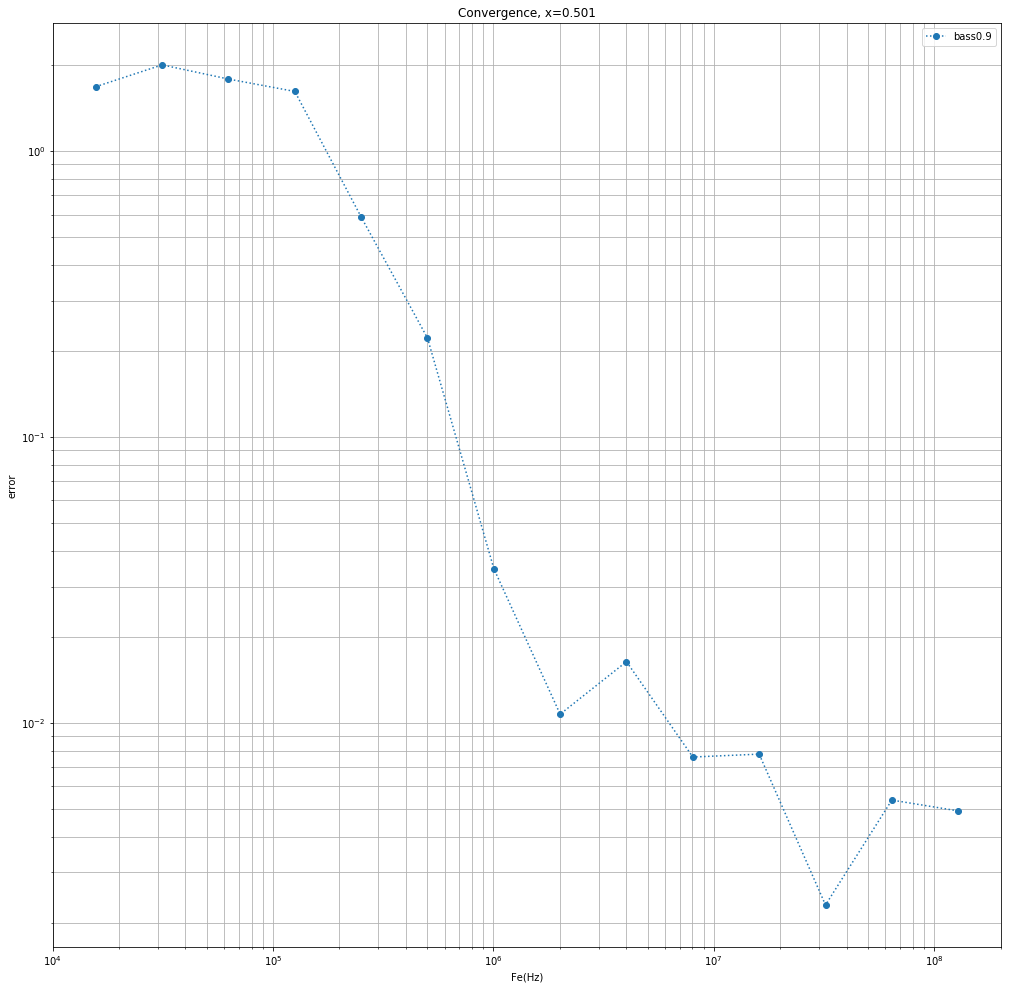

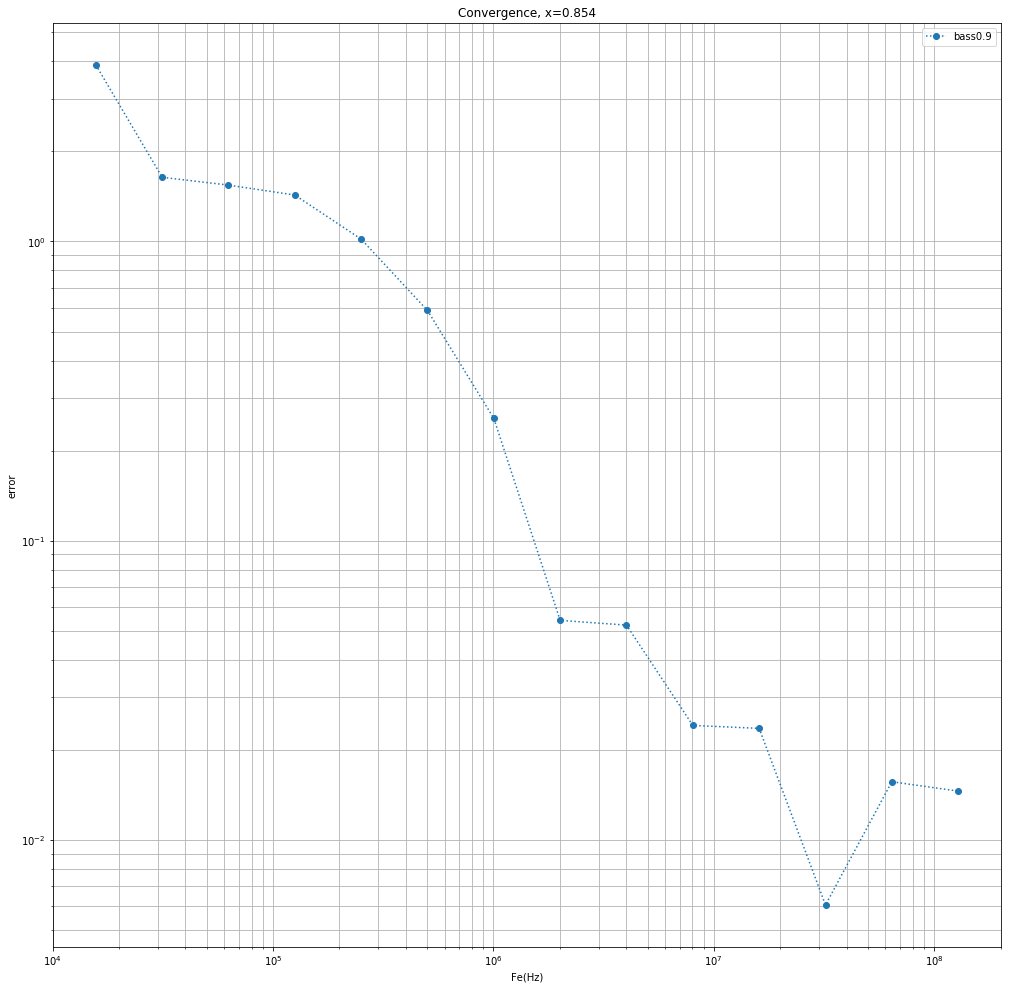

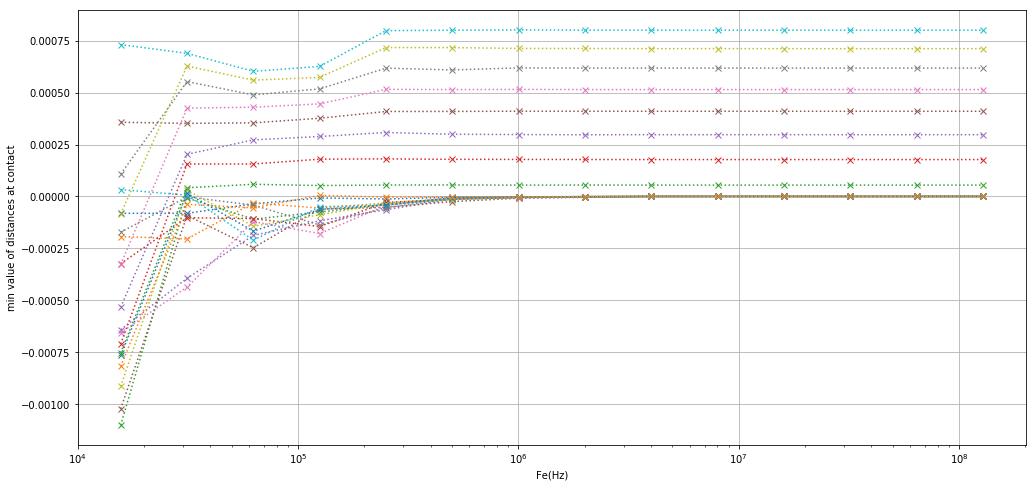

In [15]:
iplot = 388
for i in range(len(dofs)):
    fig = plot_errors(errors, freqs, i, xref, iplot, figures_path)
    iplot += 1

fig4 = plot_y(ymin, freqs, 4)
##fig4.title()
#plt.savefig(os.path.join(figures_path, 'min_y.pdf'))

In [22]:
yy = ymin['bass0.9']
fr = freqs['bass0.9']
yy.shape

(15, 20)

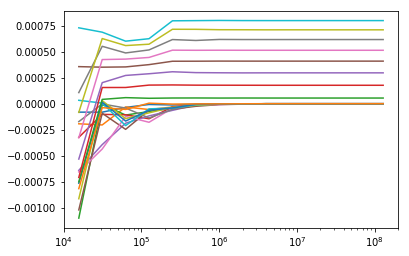

In [26]:
for i in range(20):
    plt.semilogx(fr, yy[:-1, i])

#### Save results (errors ...) in pkl file

In [ ]:
date = datetime.datetime.now().isoformat()
bckpfilename = os.path.join(figures_path, 'backup' + str(date) + '.pkl')
print('backup to file ' + bckpfilename + ' ...')
bckpfile = open(bckpfilename, 'wb')
backups = (errors, ymin, freqs)
pickle.dump(backups, bckpfile)


In [ ]:
# To load a file:
bckpfile = open('fig_campaign0212/backup2017-12-13T14:26:26.296423.pkl', 'rb')
#bckpfile = open('fig_campaign_new_0612/backup2017-12-14T11:16:22.928082.pkl', 'rb')

results = pickle.load(bckpfile)
err = results[0]
fre = results[2]
bckpfile.close()


for name in errors:
    err[name] = errors[name]
    fre[name] = freqs[name]

In [ ]:

fig = plot_errors(err, fre, 0, 23)
fig.title("Convergence, x=0.01")
plt.savefig(os.path.join(figures_path, 'comp_cvg_x=0.01.pdf'))
fig1 = plot_errors(err, fre, 1, 1)
fig1.title("Convergence, x=0.4")  
plt.savefig(os.path.join(figures_path, 'comp_cvg_x=0.4.pdf'))
fig2 = plot_errors(err, fre, 2, 2)
fig2.title("Convergence, x=0.8")  
plt.savefig(os.path.join(figures_path, 'comp_cvg_x=0.8.pdf'))
#fig4 = plot_y(ymin, freqs, 4)
#fig4.title()
#plt.savefig(os.path.join(figures_path, 'min_y.pdf'))

### plot simulations durations

In [ ]:
fig = plot_durations(timers)
plt.savefig(os.path.join(figures_path, 'Durations.pdf'))